In [136]:
import io
import json
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

%matplotlib inline

# data gen
def synthesize(seed=12, num_obv=5000):
    np.random.seed(seed)

    x1 = np.random.multivariate_normal([0, 0], [[1, .75], [.75, 1]], num_obv)
    x2 = np.random.multivariate_normal([1, 4], [[1, .75], [.75, 1]], num_obv)

    x = np.vstack((x1, x2)).astype(np.float32)
    labels = np.hstack((np.zeros(num_obv), np.ones(num_obv)))
    return x, labels, seed


# viz tools
def scatter_synth(x, labels):
    plt.figure(figsize=(12, 8))
    plt.title('labeled synthetic x')
    plt.scatter(x[:, 0], x[:, 1], c=labels, alpha=0.4)
    plt.show()

In [69]:
# "activiation"
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [147]:
def log_likelihood(x, y, w):
    avg = np.dot(x, w)
    ll = np.sum(y * avg - np.log(1 + np.exp(avg)))
    return ll

In [71]:
# derive the gradient
def d_log_liklihood(x, y, yh):
    return np.dot(x.T, y - yh)

In [137]:
# disk tools
# write out as .npy and .json
# TODO pull these two apart
def serialize_to_disk(w, basename):
    with open('{}.npy'.format(basename), 'wb') as f:
        np.save(f, w)
        
    with open('{}.npy.json'.format(basename), 'w') as f:
        mf = io.BytesIO()
        np.save(mf, w)
        mf.seek(0)
        decoded = mf.read().decode('latin-1')
        s = json.dumps({ "weights": decoded })
        f.write(s)
        # f.save()

# reads .json
# use np.load(fileObj) to read .npy files
def read_from_json(path):
    with open(path, 'r') as f:
        mf = io.BytesIO()
        # already deserialized from json string
        js = json.loads(f.read())
        mf.write(js['weights'].encode('latin-1'))
        mf.seek(0)
        a = np.load(mf)
        return a

### demo
# w = np.array([0, 3, 4, 5])
# print(w)
# serialize_to_disk(w, 'weights')
# w1 = read_from_json('./weights.npy.json')
# print(w == w1) # [ True  True  True  True]
###

seed set to 12


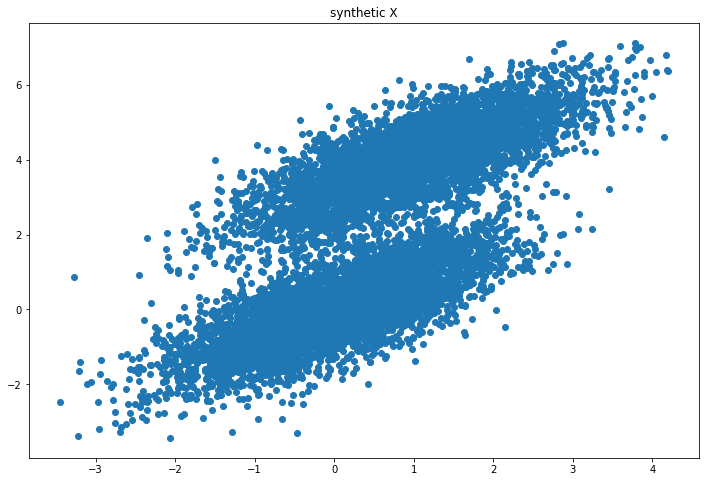

x dimensions (10000, 3)

first 10 of x
 [[ 1.         -0.2015173  -0.68335819]
 [ 1.          0.37451947 -0.8280822 ]
 [ 1.         -0.16189468 -1.24710655]
 [ 1.          0.03771096 -0.04730284]
 [ 1.         -0.26047906  1.77020395]
 [ 1.          0.39217335  0.72625089]
 [ 1.         -0.59554601 -1.45480013]
 [ 1.         -1.21247292 -1.29884589]
 [ 1.         -0.62401998 -1.27022302]
 [ 1.          0.53530967  1.39076495]]

weights initialized to
 [0. 0. 0.]
weights [-12.56532549  -4.51997065   7.409311  ]
duration 0:00:06.431765


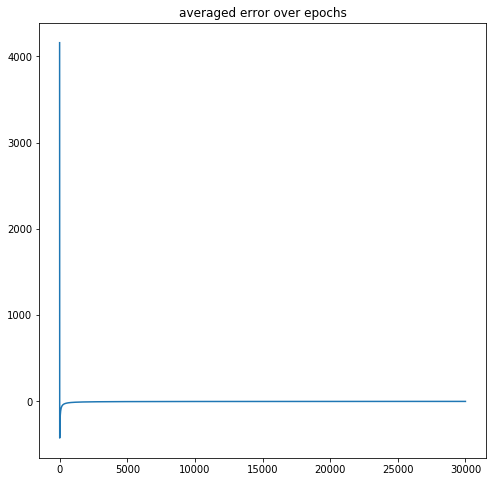

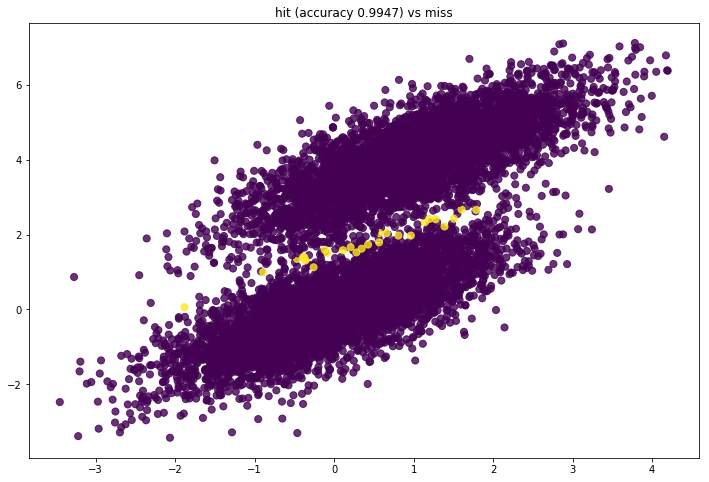

seed set to 1302


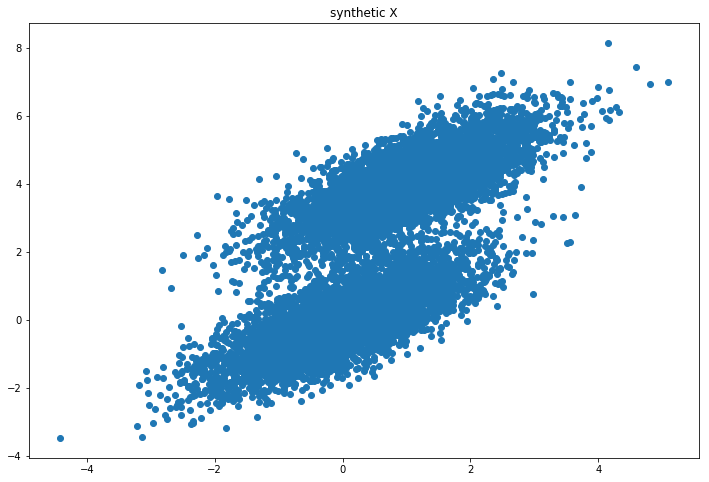

x dimensions (10000, 3)

first 10 of x
 [[ 1.         -0.55703431 -0.21054201]
 [ 1.          0.53195387  0.99219054]
 [ 1.         -0.63654035 -0.51711029]
 [ 1.         -0.33373916  0.95923156]
 [ 1.         -0.98493987 -1.21368825]
 [ 1.          1.57274258  1.4690901 ]
 [ 1.          0.98824728 -0.46166694]
 [ 1.         -0.56871879 -0.57631338]
 [ 1.          0.366355    0.40735394]
 [ 1.          0.59757769  0.98483354]]

weights initialized to
 [0. 0. 0.]
weights [-11.5272955   -4.32718148   6.95932301]
duration 0:00:06.376023


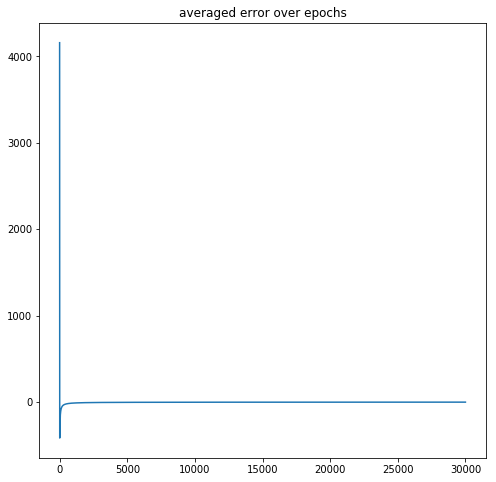

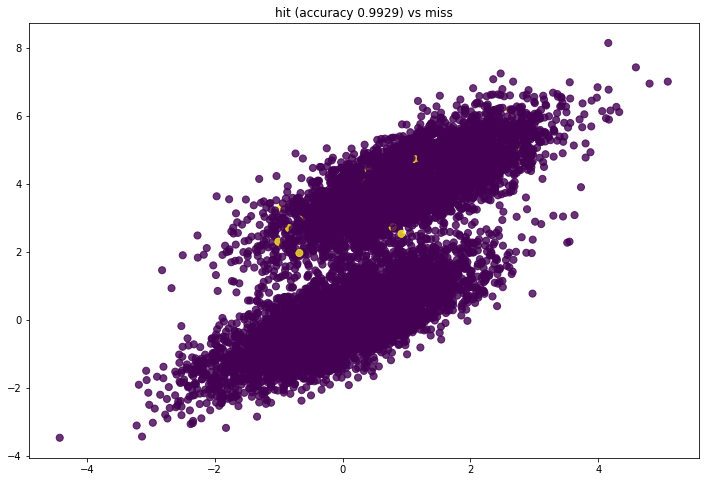

seed set to 489


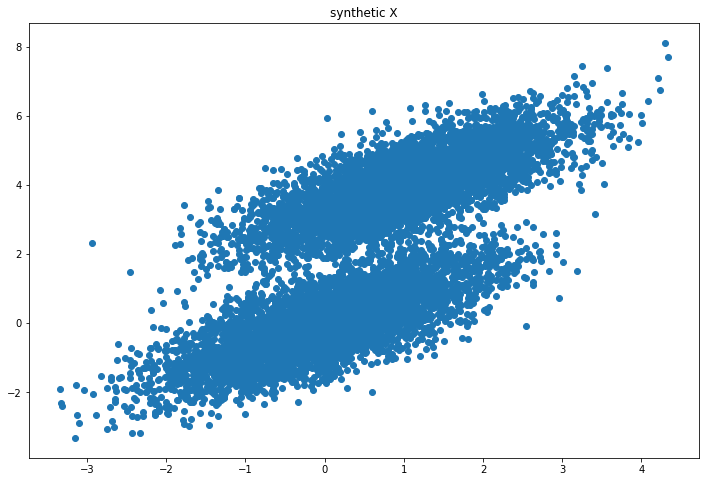

x dimensions (10000, 3)

first 10 of x
 [[ 1.         -1.32248223 -1.40195727]
 [ 1.         -0.90748739  0.38437489]
 [ 1.          2.54700685 -0.095864  ]
 [ 1.         -0.90466905 -1.06358671]
 [ 1.         -0.70684844 -0.04171505]
 [ 1.         -0.99012375  0.3624222 ]
 [ 1.          0.19586419  0.56891781]
 [ 1.         -1.40327704 -0.94768035]
 [ 1.          0.49995893  1.05524695]
 [ 1.          2.07746601  1.19382799]]

weights initialized to
 [0. 0. 0.]
weights [-12.01656667  -4.4816533    7.12474868]
duration 0:00:06.387454


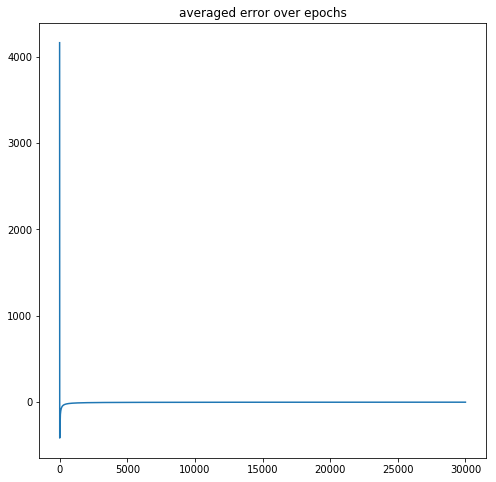

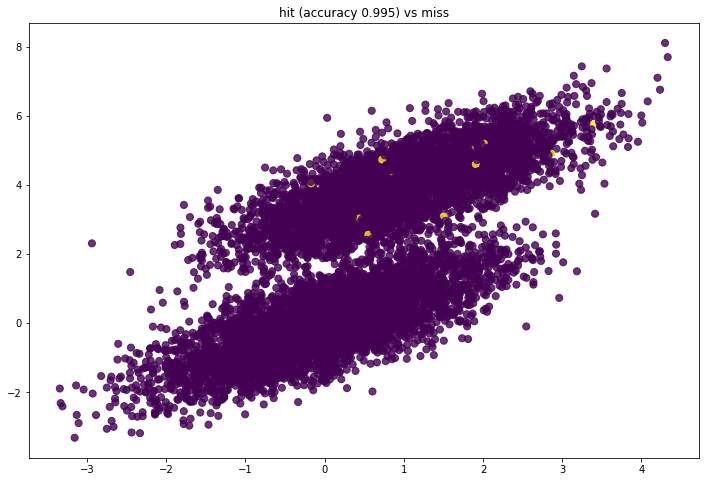

In [148]:
def train(x, y, epochs, learn_rate, add_intercept = False):
    if add_intercept:
        itc = np.ones((x.shape[0], 1))
        x = np.hstack((itc, x))
        
    # random weights?
    w = np.zeros(x.shape[1])

    print('x dimensions', x.shape)
    print('\nfirst 10 of x\n', x[:10, :])
    print('\nweights initialized to\n', w)

    progress_file = open('training-progress.txt', 'w')
    
    errs = []
    start = datetime.now()
    
    # logistic regression
    # maximum likelihood estimation
    for epoch in range(epochs):
        # predict
        yh = sigmoid(np.dot(x, w))
        
        # derive gradient
        err = d_log_liklihood(x, y, yh)
        
        errs.append(np.average(err))

        # update weights
        w += learn_rate * err
        
        if epoch % 1000 == 0:
            progress_file.write(json.dumps({'epoch': epoch, 'log_likelihood': log_likelihood(x, y, w)}) + '\n')

    return w, errs, datetime.now() - start


def predict(w, x):
    # add intercept
    x = np.hstack((np.ones((x.shape[0], 1)), x))

    return np.round(sigmoid(np.dot(x, w)))


data = [
    synthesize(12, 5000),
    synthesize(1302, 5000),
    synthesize(489, 5000),
]
# scatter_synth(synthX, labels)

for (synthX, labels, seed) in data:
    # reinstating the seed used to generate the synthetic data
    np.random.seed(seed)
    
    print('seed set to {}'.format(seed))
    
    plt.figure(figsize = (12, 8))
    plt.scatter(synthX[:, 0], synthX[:, 1])
    plt.title('synthetic X')
    plt.show()
    
  
    w, errs, dur = train(synthX, labels, 30000, learn_rate=4e-5, add_intercept=True)
    
    serialize_to_disk(w, 'weights-e1-{}'.format(datetime.today()))

    print('weights', w)
    print('duration', dur)
    
    plt.figure(figsize = (8, 8))
    plt.title('averaged error over epochs')
    plt.plot(errs)
    plt.show()

    p = predict(w, synthX)

    plt.figure(figsize = (12, 8))
    plt.scatter(synthX[:, 0], synthX[:, 1], c = predictions == labels - 1, alpha = 0.8, s = 50)
    plt.title('hit (accuracy {}) vs miss'.format((p == labels).sum().astype(float) / len(p)))
    plt.show()